In [1]:
from RewardingVisualDoubt import infrastructure
from RewardingVisualDoubt.dataset import mimic_cxr

infrastructure.make_ipython_reactive_to_changing_codebase()

from RewardingVisualDoubt import dataset  # inference, prompter, shared, vllm
import plot_mimic_cxr

In [50]:
mimic_cxr_df = mimic_cxr.create_mimic_cxr_dataset_df()
mimic_cxr_df.head()

Loading mimic_cxr_df from cache


,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,dicom_id,split,img_path
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
1,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
2,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
3,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...
4,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,train,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...


In [77]:
df_melt = mimic_cxr.melt_mimic_cxr_df_into_binary_unambiguous_labels(mimic_cxr_df)
df_melt.head(30)

,subject_id,study_id,dicom_id,split,img_path,disease,label
0,10003502,50084553,70d7e600-373c1311-929f5ff9-23ee3621-ff551ff9,validate,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,True
1,10003502,51180958,1fa79752-9ddaf5b5-2120ae82-9fec50d6-51f48d1f,validate,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,True
2,10003502,51180958,a8319f39-9eef5bb2-5bd95b97-9dd70b0f-02a846e3,validate,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,True
6,10003502,53282957,eb2fabb7-4bbc8aab-d7371282-08e5bcb5-de2e430a,validate,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,True
12,10013502,54857277,5c531aa1-a70cc60a-7cc96a81-931ae3dd-f13b5158,validate,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,True
13,10013502,54857277,c81b70dd-6e74dfbc-dad34592-ddacfe2d-3c3a5d4c,validate,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,True
16,10057482,52168780,5799175e-c125dfdb-3bd28e88-4f9ad41b-37bdd2ed,validate,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,True
17,10057482,52168780,5eb9cc4f-c43b5757-52310877-3c87b128-465b02db,validate,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,True
33,10190940,50438069,2aafe5ea-12d26b26-972e16c4-ff3d0f9a-ae75d498,validate,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,True
34,10190940,50438069,707c7ae4-04900b82-789fd588-1d86b741-ec38124b,validate,/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/file...,Atelectasis,True


In [75]:
df = dataset.create_balanced_binary_qa_mimic_cxr_dataset_df(
    mimic_cxr_df, split=dataset.DatasetSplit.VALIDATION, num_samples_per_disease=50
)

Atelectasis: only 38 samples available (pos=25, neg=13)
Fracture: only 37 samples available (pos=25, neg=12)
Lung Lesion: only 38 samples available (pos=25, neg=13)
Pleural Other: only 22 samples available (pos=22, neg=0)
Saving balanced_binary_qa_mimic_cxr_df_validate_50_samples_per_disease to cache


In [82]:
dataset_report = plot_mimic_cxr.create_binary_qa_dataset_report(df_melt)
dataset_report["validate"]

,count,true_count,false_count,percent_true,percent_false
Atelectasis,541,528,13,97.60,2.40
Cardiomegaly,740,534,206,72.16,27.84
Consolidation,210,113,97,53.81,46.19
Edema,648,326,322,50.31,49.69
Enlarged Cardiomediastinum,179,90,89,50.28,49.72
Fracture,46,34,12,73.91,26.09
Lung Lesion,122,109,13,89.34,10.66
Lung Opacity,590,560,30,94.92,5.08
Pleural Effusion,998,670,328,67.13,32.87
Pleural Other,22,22,0,100.00,0.00


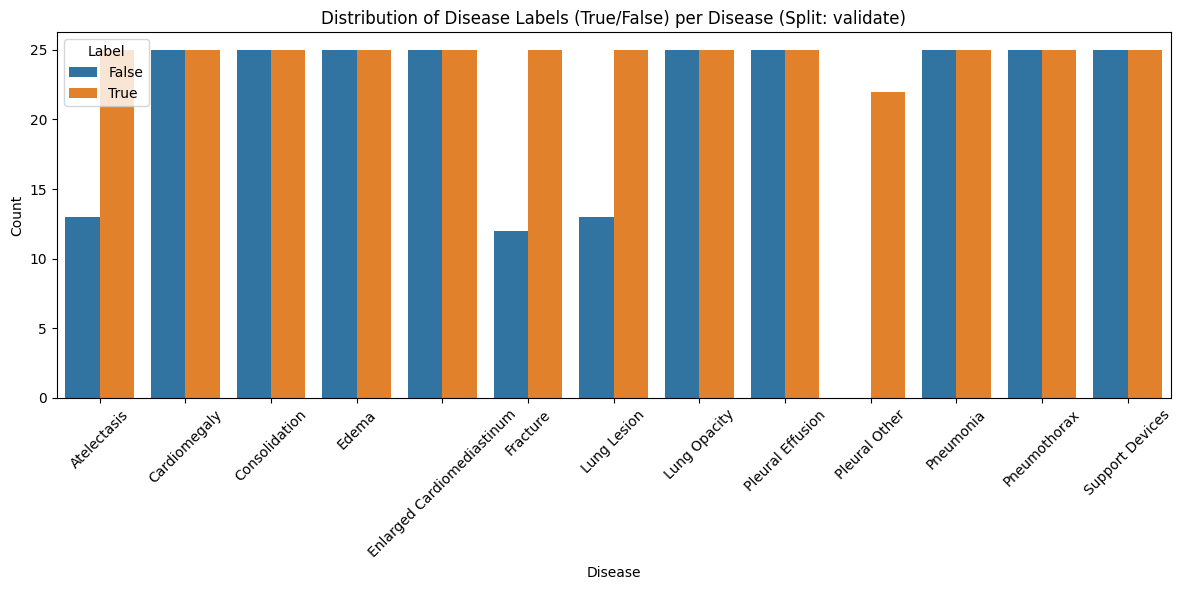

In [81]:
# plot_mimic_cxr.plot_num_datapoints_per_disease(df_melt, split=dataset.DatasetSplit.VALIDATION)
plot_mimic_cxr.plot_num_datapoints_per_disease(df, split=dataset.DatasetSplit.VALIDATION)

# General Mmimic Cxr dataset stats

In [ ]:
import pandas as pd

split_df = pd.read_csv(mimic_cxr.MIMIC_CXR_SPLIT_CSV_PATH)
print("Train split size:", sum(split_df["split"] == "train"))
print("Val split size:", sum(split_df["split"] == "validate"))
print("Test split size:", sum(split_df["split"] == "test"))

print("Total dataset size:", len(split_df))

Train split size: 368960
Val split size: 2991
Test split size: 5159
Total dataset size: 377110


In [6]:
mimic_cxr_df["Lung Lesion"].value_counts()

Lung Lesion
 1.0    10801
-1.0     2027
 0.0     1719
Name: count, dtype: int64

In [7]:
mimic_cxr_df.columns

Index(['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices',
       'dicom_id', 'split', 'img_path'],
      dtype='object')

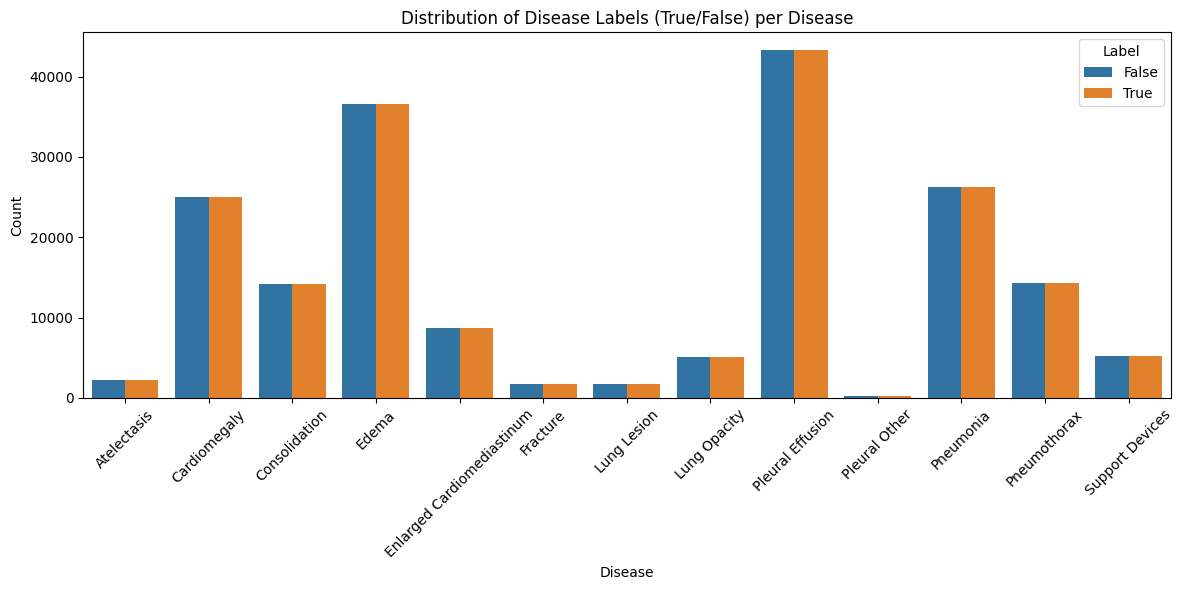

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=balanced_df, x="disease", hue="label", order=sorted(balanced_df["disease"].unique())
)

# Customize the plot
plt.xticks(rotation=45)
plt.title("Distribution of Disease Labels (True/False) per Disease")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.legend(title="Label", labels=["False", "True"])
plt.tight_layout()

# Display the plot
plt.show()